## This is a proof-of-concept to clean up a noisy sinusoidal signal using ML algorithm.


### First we import all necessary libraries

In [65]:
%matplotlib inline
import numpy as np
from numpy.random import seed
from numpy.random import randn
import matplotlib.pyplot as plt
import random

### Then change the default display settings for the plots

In [66]:
plt.rc('figure', figsize=(12,6))

### Generate and plot the sinusoidal signal

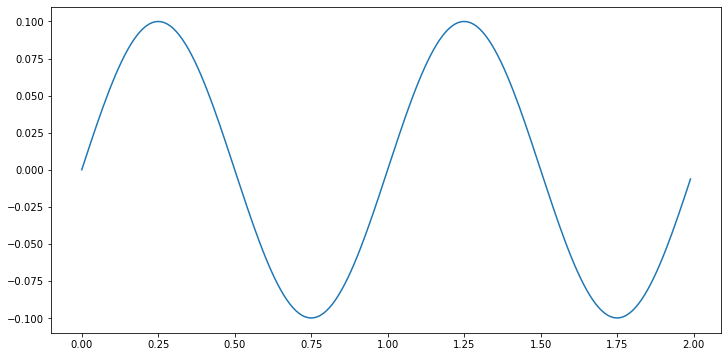

In [67]:
dt = 0.01
t = np.arange(0, 2, dt)
s = 0.1 * np.sin(2 * np.pi * t) 
plt.plot(t,s)
plt.show()

### Add noise to the signal and plot

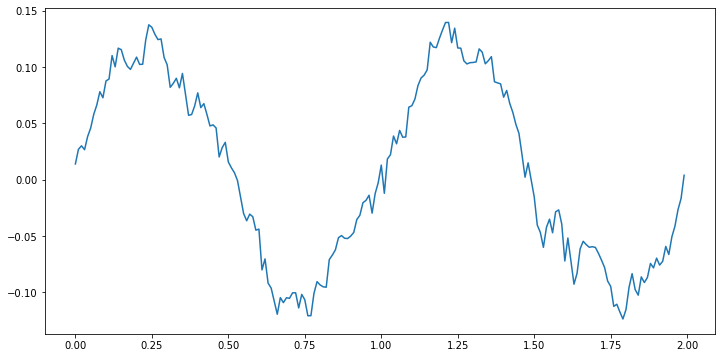

In [68]:
nse = randn(len(t))
r = np.exp(-t / 0.05)
cnse = np.convolve(nse, r) * dt
cnse = cnse[:len(t)]
s = 0.1 * np.sin(2 * np.pi * t) + cnse
plt.plot(t,s)
plt.show()

### Then label the x and y axis and add a title

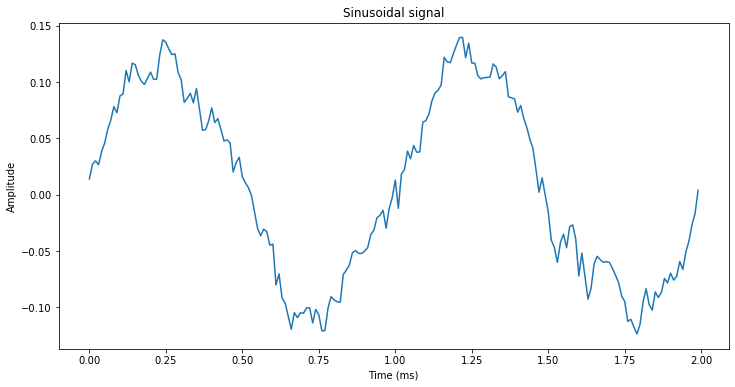

In [69]:
plt.plot(t,s)
plt.ylabel("Amplitude")
plt.xlabel("Time (ms)")
plt.title("Sinusoidal signal")
plt.show()

### Generating the noisy signal datasets

In [70]:
def generate_datasets(n_samples):
    '''
    This generates the datasets for x and y values of the sinusoidal signal. 
    It returns an array corresponding to the x and y values of the clean signal,
    and the noisy signal. The inner array contains three elements:
        index 0 refers to the time(x axis).
        index 1 refers to the amplitude of the noisy signal(y axis), and 
        index 2 refers to the amplitude of the clean signal(y axis).
    The number of datasets generated is specified by the argument n_samples.
    The returned array is of shape [samples[time,noisy signal, clean signal]].
    '''

    batch_sig = []
    batch_y = []
    
    # Fixing random state for reproducibility
    seed(42)

    for _ in range(n_samples):
        dt = 0.01
        amplitude = 0.1
        t = np.arange(0, 2, dt)

        nse = randn(len(t))
        r = np.exp(-t / 0.05)
        cnse = np.convolve(nse, r) * dt
        cnse = cnse[:len(t)]
        s = 0.1 * np.sin(2 * np.pi * t)
        s_cnse = 0.1 * np.sin(2 * np.pi * t) + cnse

        sig_ = np.array([t, s_cnse, s])
        
        sig_ = sig_.T

        batch_sig.append(sig_)

    #batch_sig = np.array(batch_sig)

    return batch_sig

### Getting 3 sets of data (clean and noisy)

In [71]:
some_data = generate_datasets(3)

### Plotting the clean and noisy signal

In [72]:
def plot_signals(data):
    '''Plots the dataset for the signal.
        first argument: The dataset.
    '''
    for _ in range(len(data)):
        if _ == 0:
            plt.plot(data[_].T[0], data[_].T[2], '--', label = 'Clean Signal ')

        plt.plot(data[_].T[0], data[_].T[1], label = 'Noisy Signal Number ' + str(_+1))
        plt.ylabel("Amplitude")
        plt.xlabel("Time (ms)")
        plt.title("Sinusoidal signal")
        plt.legend(loc = 'lower left')
    plt.show()

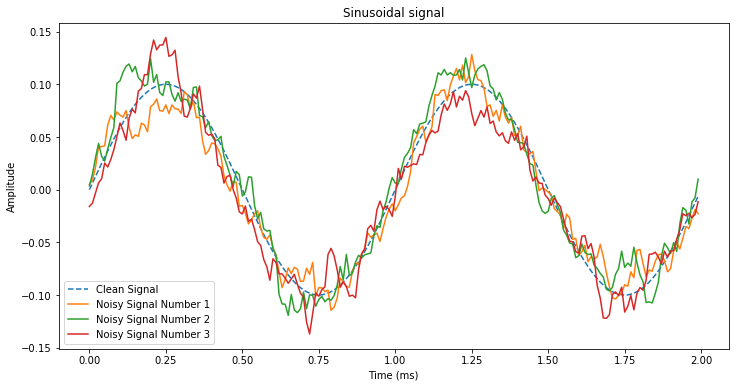

In [73]:
plot_signals(some_data)

### Now, let's do some ML. Let the fun/pain begin!!!

### Try fit on some instances

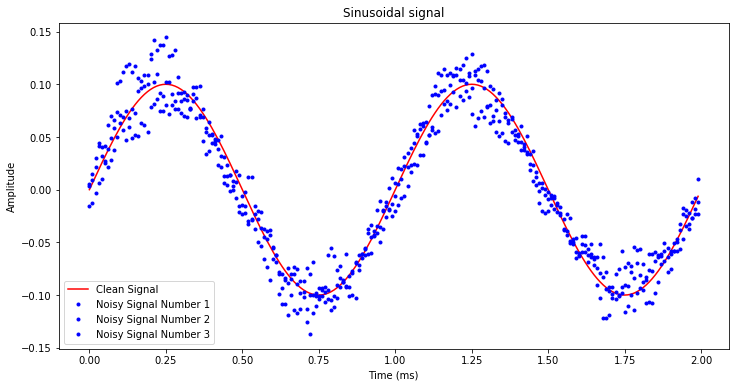

In [74]:
X = some_data[0].T[0]
Y = some_data[0].T[1]
for _ in range(len(some_data)):
    if _ == 0:
        plt.plot(some_data[_].T[0], some_data[_].T[2], 'r', label = 'Clean Signal ')

    plt.plot(some_data[_].T[0], some_data[_].T[1], "b.", label = 'Noisy Signal Number ' + str(_+1))
    plt.ylabel("Amplitude")
    plt.xlabel("Time (ms)")
    plt.title("Sinusoidal signal")
    plt.legend(loc = 'lower left')
plt.show()

In [75]:
X = np.array(some_data[0].T[0])
Y = np.array(some_data[0].T[1])
X = np.reshape(X, (len(X),1))
Y = np.reshape(Y, (len(Y),1))

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

X[1]

array([0.01])

In [77]:
X_poly[1]

array([0.01  , 0.0001])

In [78]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y)
lin_reg.intercept_, lin_reg.coef_

(array([0.03820788]), array([[-0.03977389, -0.00038403]]))

### Perform some predictions with a newly generated test data. 

In [79]:
def generate_test_data():

    dt = 0.01
    amplitude = 0.1
    t = np.arange(0, 2, dt)

    nse = randn(len(t))
    r = np.exp(-t / 0.05)
    cnse = np.convolve(nse, r) * dt
    cnse = cnse[:len(t)]
    s = 0.1 * np.sin(2 * np.pi * t)
    s_cnse = 0.1 * np.sin(2 * np.pi * t) + cnse

    sig_ = np.array([t, s_cnse, s])
        
    sig_ = sig_.T
    return sig_

In [80]:
len(cnse)

200

In [81]:
test_data = generate_test_data()

X_new = np.array(test_data.T[0])
#Y_new = np.array(test_data.T[1])
X_new = np.reshape(X, (len(X),1))
Y_new = np.reshape(Y, (len(Y),1))


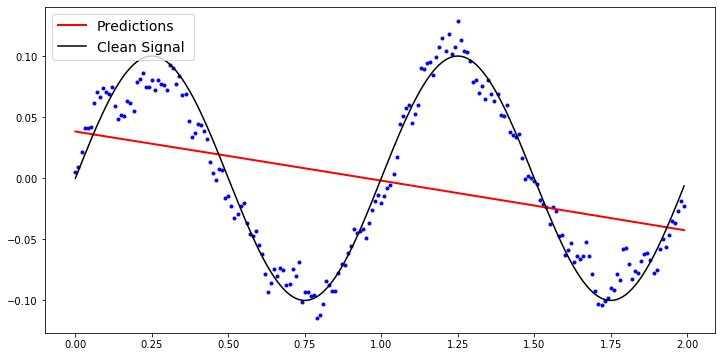

In [82]:
X_new_poly = poly_features.transform(X_new)
Y_new = lin_reg.predict(X_new_poly)
plt.plot(X,Y,"b.")
plt.plot(X_new, Y_new, "r-", linewidth=2, label="Predictions")
plt.plot(some_data[_].T[0], some_data[_].T[2], 'k', label = 'Clean Signal ')
plt.legend(loc="upper left", fontsize = 14)
plt.show()



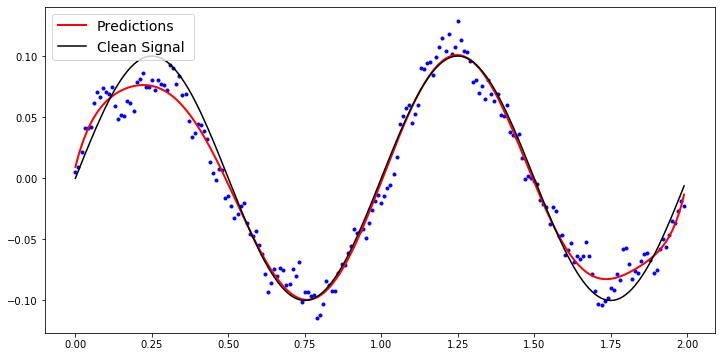

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

polybig_features = PolynomialFeatures(degree=10, include_bias=False)
std_scaler = StandardScaler()
lin_reg = LinearRegression()
polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
polynomial_regression.fit(X, Y)
Y_newbig = polynomial_regression.predict(X_new)

plt.plot(X,Y,"b.")
plt.plot(X_new, Y_newbig, "r-", linewidth=2, label="Predictions")
plt.plot(some_data[_].T[0], some_data[_].T[2], 'k', label = 'Clean Signal ')
plt.legend(loc="upper left", fontsize = 14)
plt.show()


In [84]:
len(Y)

200

### Now, let's plot the model's performance on the training set and the validation set as a function of the training set size (or the training iteration)

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

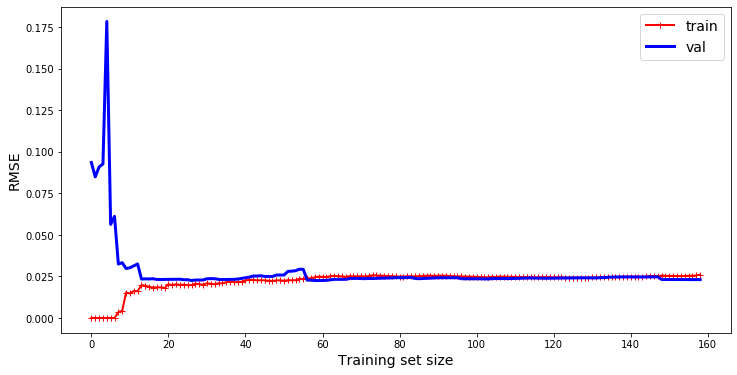

In [86]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X_poly, Y)
#plt.axis([0, 80, 0, 3])
#save_fig("learning_curves_plot")
plt.show()